In [1]:
from keras.utils import image_dataset_from_directory, set_random_seed
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Rescaling
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import BinaryAccuracy, Precision, Recall
import matplotlib.pyplot as plt
from numpy import asarray

In [2]:
set_random_seed(10)

In [3]:
img_size = (1024, 1024)
dataset_dir = '/Users/snoopy/Desktop/Other/Harvard/Final Project/pediatric-chest-xrays/chest_xray'

In [4]:
train_data = image_dataset_from_directory(directory=dataset_dir+'/train',
                                          label_mode='binary',
                                          class_names=['NORMAL', 'PNEUMONIA'],
                                          color_mode='grayscale',
                                          image_size=img_size,
                                          shuffle=True)
test_data = image_dataset_from_directory(directory=dataset_dir+'/test',
                                          label_mode='binary',
                                          class_names=['NORMAL', 'PNEUMONIA'],
                                          color_mode='grayscale',
                                          image_size=img_size)
val_data = image_dataset_from_directory(directory=dataset_dir+'/val',
                                          label_mode='binary',
                                          class_names=['NORMAL', 'PNEUMONIA'],
                                          color_mode='grayscale',
                                          image_size=img_size)

Found 5216 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


2022-07-30 12:00:55.649386: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-30 12:00:55.649484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
train_len = train_data.__len__().numpy()
val_len = int(train_len * 0.2)
val_data = val_data.concatenate(train_data.take(val_len))
train_data = train_data.skip(val_len)

In [6]:
dim1, dim2 = img_size

In [7]:
model = Sequential()
model.add(Rescaling(scale=1./255, offset=0.0, input_shape=(dim1, dim2, 1)))
model.add(Conv2D(filters=5, kernel_size=8, strides=4, padding='valid', activation='selu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Conv2D(filters=10, kernel_size=4, strides=2, padding='same', activation='selu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Conv2D(filters=15, kernel_size=2, strides=1, padding='same', activation='selu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
model.add(Flatten())
model.add(Dense(units=150, activation='selu'))
model.add(Dense(units=50, activation='selu'))
model.add(Dense(units=10, activation='selu'))
model.add(Dense(units=1, activation='sigmoid'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1024, 1024, 1)     0         
                                                                 
 conv2d (Conv2D)             (None, 255, 255, 5)       325       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 5)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 10)        810       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 15)        6

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[BinaryAccuracy(name='accuracy'),
                       Precision(thresholds=0.5, name='precision'),
                       Recall(thresholds=0.5, name='recall')])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001,
                               patience=10,
                               verbose=1,
                               mode='min',
                               restore_best_weights=True)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              mode='min',
                              min_delta=0.0001)

In [12]:
history = model.fit(train_data,
                    epochs=50,
                    verbose=1,
                    callbacks=[early_stopping, reduce_lr],
                    validation_data=val_data,
                    shuffle=True)

Epoch 1/50


2022-07-30 12:00:56.452887: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-30 12:00:56.453209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.8547 - precision: 0.8725 - recall: 0.9418

2022-07-30 12:01:24.761970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 32s 220ms/step - loss: 0.3414 - accuracy: 0.8547 - precision: 0.8725 - recall: 0.9418 - val_loss: 0.1350 - val_accuracy: 0.9510 - val_precision: 0.9614 - val_recall: 0.9727 - lr: 0.0010
Epoch 2/50
131/131 [==============================] - 29s 209ms/step - loss: 0.1029 - accuracy: 0.9652 - precision: 0.9741 - recall: 0.9791 - val_loss: 0.0974 - val_accuracy: 0.9654 - val_precision: 0.9679 - val_recall: 0.9856 - lr: 0.0010
Epoch 3/50
131/131 [==============================] - 30s 213ms/step - loss: 0.0885 - accuracy: 0.9673 - precision: 0.9761 - recall: 0.9801 - val_loss: 0.0807 - val_accuracy: 0.9731 - val_precision: 0.9829 - val_recall: 0.9803 - lr: 0.0010
Epoch 4/50
131/131 [==============================] - 29s 209ms/step - loss: 0.0831 - accuracy: 0.9709 - precision: 0.9798 - recall: 0.9810 - val_loss: 0.1221 - val_accuracy: 0.9538 - val_precision: 0.9487 - val_recall: 0.9908 - lr: 0.0010
Epoch 5/50
131/131 [==============================]

In [13]:
model.save('pediatric_simple_cnn_30_July_2022', overwrite=False, include_optimizer=True)

INFO:tensorflow:Assets written to: pediatric_simple_cnn_30_July_2022/assets


INFO:tensorflow:Assets written to: pediatric_simple_cnn_30_July_2022/assets


In [14]:
train_precision = asarray(history.history['precision'])
train_recall = asarray(history.history['recall'])
val_precision = asarray(history.history['val_precision'])
val_recall = asarray(history.history['val_recall'])
train_f1 = 2./(1./train_precision+1./train_recall)
val_f1 = 2./(1./val_precision+1./val_recall)

In [15]:
epochs = range(len(history.history['loss']))

In [16]:
print("Train precision: ", train_precision[-1])
print("Train recall: ", train_recall[-1])
print("Validation precision: ", val_precision[-1])
print("Vlaidation recall: ", val_recall[-1])
print("F1 score in train set: ", train_f1[-1])
print("F1 score on validation set: ", val_f1[-1])

Train precision:  1.0
Train recall:  1.0
Validation precision:  0.9844357967376709
Vlaidation recall:  0.9934555292129517
F1 score in train set:  1.0
F1 score on validation set:  0.9889250967356856


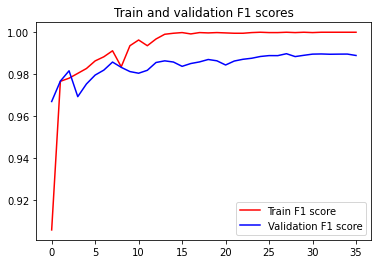

In [17]:
plt.figure()
plt.plot(epochs, train_f1, 'r', label='Train F1 score')
plt.plot(epochs, val_f1, 'b', label='Validation F1 score')
plt.title('Train and validation F1 scores')
plt.legend()
plt.show()

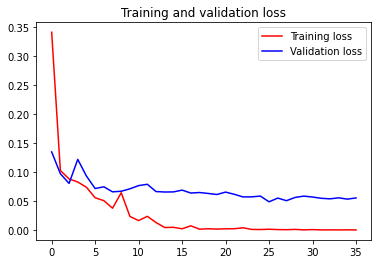

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

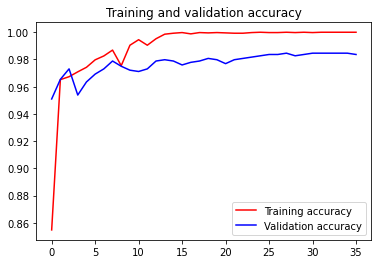

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [20]:
test_history = model.evaluate(test_data,
                              verbose=1)

20/20 [==============================] - 2s 64ms/step - loss: 1.8364 - accuracy: 0.7564 - precision: 0.7220 - recall: 0.9923


In [21]:
test_acc = test_history[1]
test_precision = test_history[2]
test_recall = test_history[3]
test_f1 = 2./(1./test_precision+1./test_recall)

In [22]:
print("Test accuracy: ", test_acc)
print("Test precision: ", test_precision)
print("Test recall: ", test_recall)
print("F1 score on test set: ", test_f1)

Test accuracy:  0.7564102411270142
Test precision:  0.7220149040222168
Test recall:  0.992307722568512
F1 score on test set:  0.8358531281776682
